# Setting up Our Starting Point

We first want to make sure we set up all the right modules, constants, and data frames we'll need to run all these optimizations.  We're going to call in the Halls of Fame, Concatenate them, then retrieve the top three equations from these files.  We'll be doing the actual retrieval manually, but using Pandas to sort and collate our data.

First we set up our Modules

In [1]:
import pandas as pd
import scipy.optimize as spopt
import scipy.special as spec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
pd.set_option('display.max_colwidth', -1)
import re

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


Then we set up our constants, and the Lennard Jones function, which some of our expressions use.

In [2]:
#The Constants we need and can tweak
eps = 1.55300000e-01 # well depth
r0 = 2 * 1.77670000e+00 # position of minima
sigma = r0/2**(1/6) # contact distance

base_p0 = [1,1,1,1,1,1,1,1,1]

In [3]:
lj = lambda r: 4 * eps * ( (sigma/r)**12 - (sigma/r)**6 )

Now we set up all of our Data Frames we'll need.

In [4]:
#Our Halls of Fame from Metropolis and Palmetto
hofgm = pd.read_csv('hof_greater_071122_metro.csv')
print(len(hofgm.index))
hoflm = pd.read_csv('hof_lesser_071122_metro.csv')
hofgp = pd.read_csv('hof_greater_071122_palm.csv')
hoflp = pd.read_csv('hof_lesser_071122_palm.csv')

#Our initial testing data sets
dfg = pd.read_csv('lj_hnc_greater_sigma.csv', names = ['r', 'c'], header=None)
print(len(dfg.index))
#dfg['r'] = np.divide(dfg['r'], sigma)
dfl = pd.read_csv('lj_hnc_lesser_sigma.csv', names = ['r', 'c'], header=None)
#dfl['r'] = np.divide(dfl['r'], sigma)
print(len(dfl.index))

#Data sets with different settings, half initial temperature/density/both
halfdens = pd.read_csv('lj_hnc_halfdens.cvv', sep='\s+', names = ['r', 'c'], header=None, skiprows=4).iloc[::]
halftemp = pd.read_csv('lj_hnc_halftemp.cvv', sep='\s+', names = ['r', 'c'], header=None, skiprows=4).iloc[::]
halfboth = pd.read_csv('lj_hnc_halfdens_halftemp.cvv', sep='\s+', names = ['r', 'c'], header=None, skiprows=4).iloc[::]

#Creating Lesser and Greater than sections for the new Data Sets
halfdensl = halfdens.query("r < @sigma")
halftempl = halftemp.query("r < @sigma")
halfbothl = halfboth.query("r < @sigma")

halfdensg = halfdens.query("r > @sigma")
halftempg = halftemp.query("r > @sigma")
halfbothg = halfboth.query("r > @sigma")

14213
3874
127


In [5]:
#Combining our Halls of Fame from the two sources
hofg = pd.concat([hofgm, hofgp])
hofg = hofg.drop_duplicates()

hofl = pd.concat([hoflm, hoflp])
hofl = hofl.drop_duplicates()


In [6]:
#Sorting Our Greater than Sigma Hall of Fame, then ordering it from best to worst
hofg = hofg.sort_values('r')[['r', 'nmse_test', 'expression']]
hofg = hofg.iloc[::-1]
hofg = hofg.reset_index(drop=True)

#print(hofg)

hofg_top = hofg.head(n=3)

hofg_mean = hofg_top['nmse_test'].mean()

print(hofg_mean)

4.74427309487572e-05


In [7]:
#Sorting our Less than Sigma Hall of Fame, then ordering it from best to worst
hofl = hofl.sort_values('r')[['r', 'nmse_test', 'expression']]
hofl = hofl.iloc[::-1]
hofl = hofl.reset_index(drop=True)

#print(hofl)

hofl_top = hofl.head(n=3)

hofl_mean = hofl_top['nmse_test'].mean()

print(hofl_mean)

1.2306316724241408e-06


In [8]:
overall_mean = (hofg_mean + hofl_mean)/2

print(overall_mean)

2.433668131059067e-05


 ## Gathering and Reconfiguring our Equations

In [9]:
#How many of the top expressions you want to create
n_best = 3

#Creates our Open Lists to append
gbest = []
lbest = []
g_p0 = [[]]*3
l_p0 = [[]]*3

#Creates a Dataframe that is only the Expression Column for easier calling
gexpr = hofg[['expression']]
gexpr.reset_index(drop=True)

lexpr = hofl[['expression']]
lexpr.reset_index(drop=True)

#Creates two lists, with the number of expressions selected, to be called by the reconfigurator
for n in range(n_best):
    gs = gexpr.iloc[n][0]
    ls = lexpr.iloc[n][0]
    gbest.append(gs)
    lbest.append(ls)

In [10]:
def lambdafy_equation(equation):
    '''Converts a mathematical string expression from DSO into a parameterizable lambda function.
    
    The new function has all floats converted to parameters that can be optimized for a particular 
    dataset. Exponents are treated as constants, not parameters. Standard functions are expressed 
    as numpy functions (only `sin` and `cos` at this time). The variable in teh equation is assumed
    to be `x1`.
   
    The lambda function will have the signature `x1, p0, p1, p2, ...`.
   
    Args: 
       equation
           : string expression from DSO
    Returns
       : the new lambda function, 
       an array of the original parameter values from DSO, 
       the final string version of the lambda function'''
    float_pattern = re.compile(r'''(?<=[\W\d_])        # make sure the number is not preceded by a letter or underscore
                                   (?<!\*\*)           # Assume that exponents are fixed integers and not parameters
                                   [+-]?               # leading +-
                                   (?:\d+(?:\.\d*)?|\.\d+) # mantissa, non-capturing pattern
                                   (?:[eE][+-]?\d+)?     # exponent, non-capturing pattern''',
                              re.VERBOSE)
    sin_pattern = re.compile(r'sin')
    cos_pattern = re.compile(r'cos')
    args = 'x1'

    parameters =  np.asarray(float_pattern.findall(equation), dtype = float)
    count = 0
    for i in range(100):
        equation, count = float_pattern.subn(f'p{i}', equation, count = 1)
        if count < 1:
            break
        args = f'{args}, p{i}'
    equation = sin_pattern.sub('np.sin', equation)
    equation = cos_pattern.sub('np.cos', equation)
    equation = re.sub(r'[\[\]]', '', equation)
    equation = f'lambda {args} : {equation}'
    return eval(equation), parameters, equation

In [11]:
# convert DSO expressions into lambda functions
for ibest in range(n_best):
    # the lambda functions are produced below from the the converted 
    # string expressions, so we are ignoring the lambda function output here
    _, g_p0[ibest], gbest[ibest] = lambdafy_equation(gbest[ibest])
    _, l_p0[ibest], lbest[ibest] = lambdafy_equation(lbest[ibest])

# The Initial Optimizations

We can now optimize the equations above, based on their original data set, using the collected constants as the initial guess for the constants that should go there.  If everything is set up properly, this should all work, but might take some time finding the proper expressions.

## Best Equation from Greater than Sigma

In [12]:
#Optimizing Greater Best 1
popt_g1, pcov_g1 = spopt.curve_fit(eval(gbest[0]), dfg['r'].values, dfg['c'].values, p0 = g_p0[0]) 

print(popt_g1)

[-2.18179952  2.42659347  4.34075702  9.02793632  3.71126851  1.91761007
  0.80807924]


In [13]:
sub_g1 = np.subtract(dfg['c'], eval(gbest[0])(dfg['r'], *popt_g1))
square_g1 = sub_g1**2
mean_g1 = np.mean(square_g1)
RMS_g1 = np.sqrt(mean_g1)

print(RMS_g1)

0.00033039414612817653


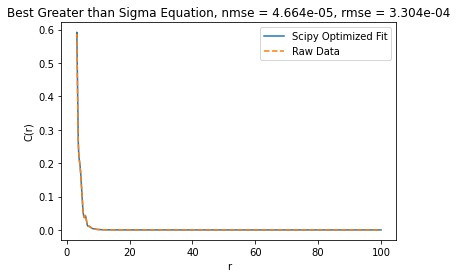

In [14]:
plt.plot(dfg['r'], eval(gbest[0])(dfg['r'], *popt_g1), label= 'Scipy Optimized Fit')
plt.plot(dfg['r'], dfg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, nmse = {:.3e}, rmse = {:.3e}'.format(hofg.iloc[0][1], RMS_g1))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

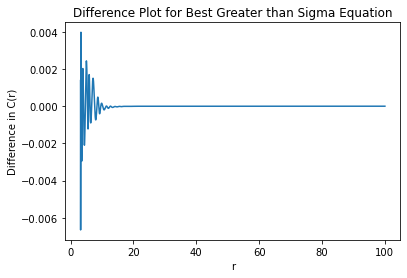

In [15]:
#Difference Plot
plt.plot(dfg['r'], sub_g1)
plt.title('Difference Plot for Best Greater than Sigma Equation')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

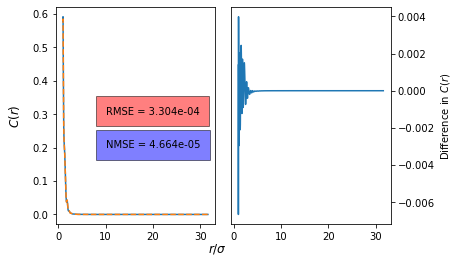

In [16]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.1)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Greater than Sigma Equation')
ax1.plot(dfg['r']/sigma, eval(gbest[0])(dfg['r'], *popt_g1), label= 'Scipy Optimized Fit')
ax1.plot(dfg['r']/sigma, dfg['c'], '--', label = 'Raw Data')
#ax1.set_yscale('log')
ax1.text(10, 0.3, r'RMSE = {:.3e}'.format(RMS_g1), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax1.text(10, 0.2, r'NMSE = {:.3e}'.format(hofg.iloc[0][1]), bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(dfg['r']/sigma, sub_g1)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.03, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

#plt.subplots_adjust(hspace=1)

fig.savefig('ljgreat1.png',dpi=300, bbox_inches = "tight")

## Second Best Equation from Greater than Sigma

In [17]:
#Optimizing Greater Best 1
popt_g2, pcov_g2 = spopt.curve_fit(eval(gbest[1]), dfg['r'].values, dfg['c'].values, p0 = g_p0[1], maxfev=100000)  

print(popt_g2)

[-2.17365517  2.41330157  4.34219828  9.03360617  7.26245674  1.80951318
  3.60896626]


In [18]:
sub_g2 = np.subtract(dfg['c'], eval(gbest[1])(dfg['r'], *popt_g2))
square_g2 = sub_g2**2
mean_g2 = np.mean(square_g2)
RMS_g2 = np.sqrt(mean_g2)

print(RMS_g2)

0.00036667704405771417


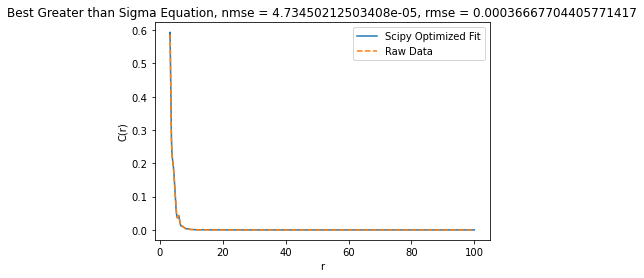

In [19]:
plt.plot(dfg['r'], eval(gbest[1])(dfg['r'], *popt_g2), label= 'Scipy Optimized Fit')
plt.plot(dfg['r'], dfg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, nmse = {}, rmse = {}'.format(hofg.iloc[1][1], RMS_g2))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

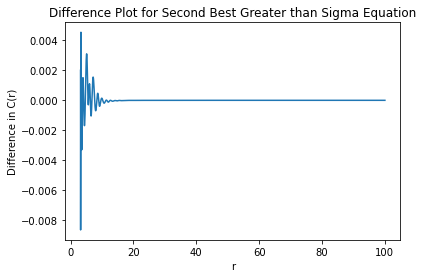

In [20]:
#Difference Plot
plt.plot(dfg['r'], sub_g2)
plt.title('Difference Plot for Second Best Greater than Sigma Equation')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

## Third Best Equation from Greater than Sigma

In [21]:
#Optimizing Greater Best 3
popt_g3, pcov_g3 = spopt.curve_fit(eval(gbest[2]), dfg['r'].values, dfg['c'].values, p0 = g_p0[2])  

print(popt_g3)

[-2.17884955  2.43446024  4.33687449  9.00872716  3.71544942  1.91462241
  0.79676482]


In [22]:
sub_g3 = np.subtract(dfg['c'], eval(gbest[2])(dfg['r'], *popt_g3))
square_g3 = sub_g3**2
mean_g3 = np.mean(square_g3)
RMS_g3 = np.sqrt(mean_g3)

print(RMS_g3)

0.00033431326314153437


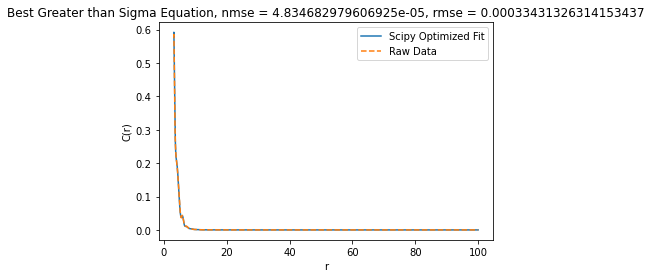

In [23]:
plt.plot(dfg['r'], eval(gbest[2])(dfg['r'], *popt_g3), label= 'Scipy Optimized Fit')
plt.plot(dfg['r'], dfg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest3(dfg['r'], *g3_p0), label='Original Fit)
plt.title('Best Greater than Sigma Equation, nmse = {}, rmse = {}'.format(hofg.iloc[2][1], RMS_g3))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


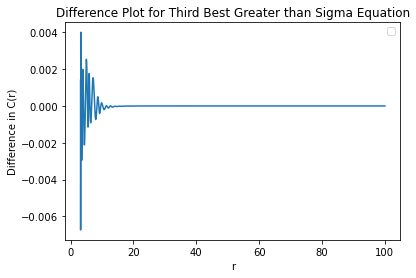

In [24]:
#Difference Plot
plt.plot(dfg['r'], sub_g3)
plt.title('Difference Plot for Third Best Greater than Sigma Equation')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
plt.legend()
#plt.yscale('log')
plt.show()

In [25]:
average_g_rmse = (RMS_g1 + RMS_g2 + RMS_g3)/3

print(average_g_rmse)

0.00034379481777580836


## Best Equation from the Less than Sigma

In [26]:
#Optimizing Lesser Best 1
popt_l1, pcov_l1 = spopt.curve_fit(eval(lbest[0]), dfl['r'].values, dfl['c'].values, p0 = l_p0[0], )

print(popt_l1)

[7.82652126e+00 4.24971816e+00 1.54508560e+04 7.83625009e-01
 5.56123725e-02 1.52275639e+00 7.33264402e-01 1.33612382e+00
 7.46223492e-01]


In [27]:
sub_l1 = np.subtract(dfl['c'], eval(lbest[0])(dfl['r'], *popt_l1))
square_l1 = sub_l1**2
mean_l1 = np.mean(square_l1)
RMS_l1 = np.sqrt(mean_l1)

print(RMS_l1)

0.005717289374384053


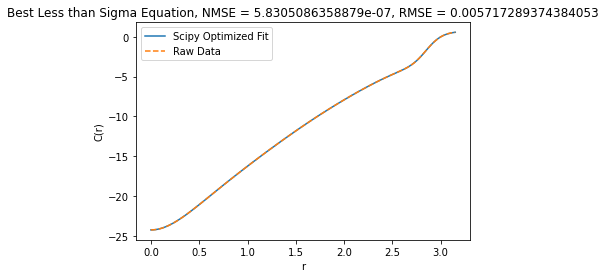

In [28]:
plt.plot(dfl['r'], eval(lbest[0])(dfl['r'], *popt_l1), label= 'Scipy Optimized Fit')
plt.plot(dfl['r'], dfl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest3(dfg['r'], *g3_p0), label='Original Fit)
plt.title('Best Less than Sigma Equation, NMSE = {}, RMSE = {}'.format(hofl.iloc[0][1], RMS_l1))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

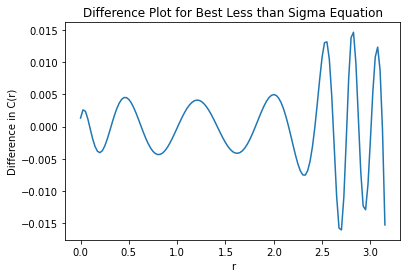

In [29]:
#Difference Plot
plt.plot(dfl['r'], sub_l1)
plt.title('Difference Plot for Best Less than Sigma Equation')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

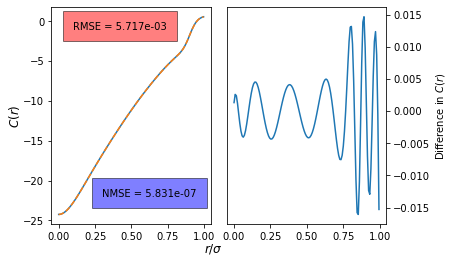

In [30]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.1)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Less than Sigma Equation')
ax1.plot(dfl['r']/sigma, eval(lbest[0])(dfl['r'], *popt_l1), label= 'Scipy Optimized Fit')
ax1.plot(dfl['r']/sigma, dfl['c'], '--', label = 'Raw Data')
ax1.text(0.1, -1, r'RMSE = {:.3e}'.format(RMS_l1), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax1.text(0.3, -22, r'NMSE = {:.3e}'.format(hofl.iloc[0][1]), bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(dfl['r']/sigma, sub_l1)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

fig.savefig('ljless1.png', dpi=300, bbox_inches = "tight")

## Second Best Equation for Less than Sigma

In [31]:
#Optimizing Lesser Best 2
popt_l2, pcov_l2 = spopt.curve_fit(eval(lbest[1]), dfl['r'].values, dfl['c'].values, p0 = l_p0[1])  

print(popt_l2)

[0.43241895 2.73266178 0.69599924 0.56447906 0.31887444 1.09296829
 2.13490507 4.36429638 0.66348365 2.97257166]


In [32]:
sub_l2 = np.subtract(dfl['c'], eval(lbest[1])(dfl['r'], *popt_l2))
square_l2 = sub_l2**2
mean_l2 = np.mean(square_l2)
RMS_l2 = np.sqrt(mean_l2)

print(RMS_l2)

0.00907044129638897


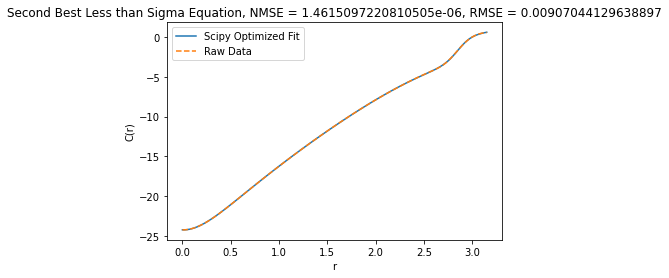

In [33]:
plt.plot(dfl['r'], eval(lbest[1])(dfl['r'], *popt_l2), label= 'Scipy Optimized Fit')
plt.plot(dfl['r'], dfl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest3(dfg['r'], *l2_p0), label='Original Fit)
plt.title('Second Best Less than Sigma Equation, NMSE = {}, RMSE = {}'.format(hofl.iloc[1][1], RMS_l2))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

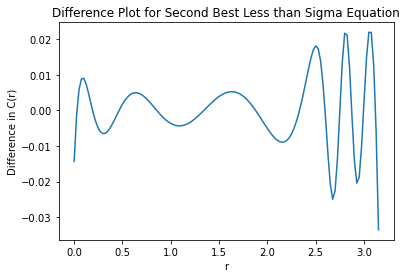

In [34]:
#Difference Plot
plt.plot(dfl['r'], sub_l2)
plt.title('Difference Plot for Second Best Less than Sigma Equation')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

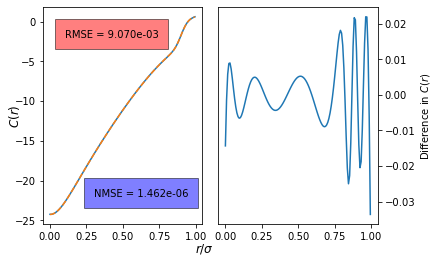

In [35]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.1)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Less than Sigma Equation')
ax1.plot(dfl['r']/sigma, eval(lbest[1])(dfl['r'], *popt_l2), label= 'Scipy Optimized Fit')
ax1.plot(dfl['r']/sigma, dfl['c'], '--', label = 'Raw Data')
ax1.text(0.1, -2, r'RMSE = {:.3e}'.format(RMS_l2), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax1.text(0.3, -22, r'NMSE = {:.3e}'.format(hofl.iloc[1][1]), bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(dfl['r']/sigma, sub_l2)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.06, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

fig.savefig('ljless2.png', dpi=300, bbox_inches = "tight")

## Third Best Less than Sigma Equation

In [36]:
#Optimizing Lesser Best 3
popt_l3, pcov_l3 = spopt.curve_fit(eval(lbest[2]), dfl['r'].values, dfl['c'].values, p0 = l_p0[2])  

print(popt_l3)

[ 6.18052975  0.37377474  5.5642851   7.55053653  1.57222054  7.79740308
 -1.29725622  1.66672463  1.11046892 17.22499154]


In [37]:
sub_l3 = np.subtract(dfl['c'], eval(lbest[2])(dfl['r'], *popt_l3))
square_l3 = sub_l3**2
mean_l3 = np.mean(square_l3)
RMS_l3 = np.sqrt(mean_l3)

print(RMS_l3)

0.009629834710857557


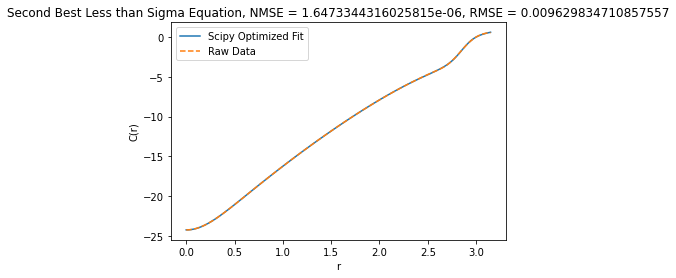

In [38]:
plt.plot(dfl['r'], eval(lbest[2])(dfl['r'], *popt_l3), label= 'Scipy Optimized Fit')
plt.plot(dfl['r'], dfl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest3(dfg['r'], *l2_p0), label='Original Fit)
plt.title('Second Best Less than Sigma Equation, NMSE = {}, RMSE = {}'.format(hofl.iloc[2][1], RMS_l3))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

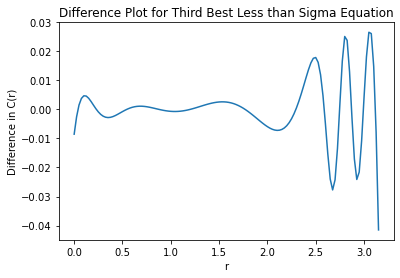

In [39]:
#Difference Plot
plt.plot(dfl['r'], sub_l3)
plt.title('Difference Plot for Third Best Less than Sigma Equation')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

In [40]:
average_l_rmse = (RMS_l1 + RMS_l2 + RMS_l3)/3

print(average_l_rmse)

average_overall_rmse = (average_g_rmse + average_l_rmse)/2

print(average_overall_rmse)

0.008139188460543527
0.004241491639159668


# Re-Optimizing Using Different Parameters

Now that we've optimized the equations, shown that their starting positions give the best configuration they can, we want to try to show transferrability.  Fundamentally this is the same process, except we will be switching out our intial data set for one configured differently:  Either with Half the initial temperature, half the initial density, or half of both.  If we can show that this still produces results with low RMSE, we can say the equation is transferrable in those ways, and could be used as a relatively fast analytic starting point for these difficult expressions.

## Best Equation on Greater Side Re-Optimizations

### Half Density

In [41]:
#Optimizing Greater Best 1 w/ Half Density
popt_gd1, pcov_gd1 = spopt.curve_fit(eval(gbest[0]), halfdensg['r'].values, halfdensg['c'].values, p0 = g_p0[0], maxfev=50000)  

In [42]:
sub_gd1 = np.subtract(halfdensg['c'], eval(gbest[0])(halfdensg['r'], *popt_gd1))
square_gd1 = sub_gd1**2
mean_gd1 = np.mean(square_gd1)
RMS_gd1 = np.sqrt(mean_gd1)

print(RMS_gd1)

0.00011708571565942199


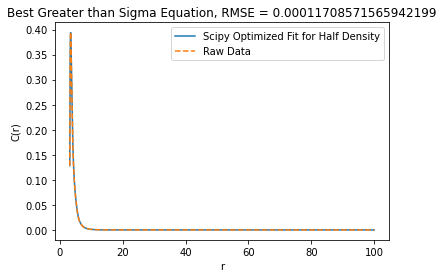

In [43]:
plt.plot(halfdensg['r'], eval(gbest[0])(halfdensg['r'], *popt_gd1), label= 'Scipy Optimized Fit for Half Density')
plt.plot(halfdensg['r'], halfdensg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_gd1))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

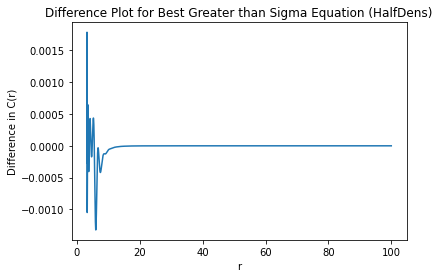

In [44]:
#Difference Plot
plt.plot(halfdensg['r'], sub_gd1)
plt.title('Difference Plot for Best Greater than Sigma Equation (HalfDens)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

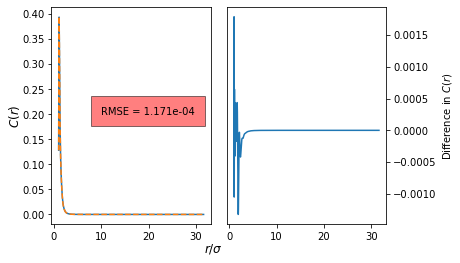

In [45]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.1)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Greater than Sigma Equation at Half Density')
ax1.plot(halfdensg['r']/sigma, eval(gbest[0])(halfdensg['r'], *popt_gd1), label= 'Scipy Optimized Fit for Half Density')
ax1.plot(halfdensg['r']/sigma, halfdensg['c'], '--', label = 'Raw Data')
ax1.text(10, 0.2, r'RMSE = {:.3e}'.format(RMS_gd1), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(halfdensg['r']/sigma, sub_gd1)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

fig.savefig('ljgreat1halfdens.png', dpi=300, bbox_inches = "tight")

### Half Temperature

In [46]:
#Optimizing Greater Best 1 w/ Half Temp
popt_gt1, pcov_gt1 = spopt.curve_fit(eval(gbest[0]), halftempg['r'].values, halftempg['c'].values, p0 = g_p0[0])  

In [47]:
sub_gt1 = np.subtract(halftempg['c'], eval(gbest[0])(halftempg['r'], *popt_gt1))
square_gt1 = sub_gt1**2
mean_gt1 = np.mean(square_gt1)
RMS_gt1 = np.sqrt(mean_gt1)

print(RMS_gt1)

0.0013854139106382912


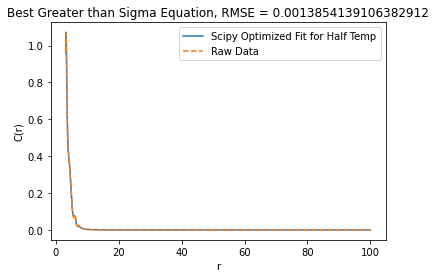

In [48]:
plt.plot(halftempg['r'], eval(gbest[0])(halftempg['r'], *popt_gt1), label= 'Scipy Optimized Fit for Half Temp')
plt.plot(halftempg['r'], halftempg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_gt1))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

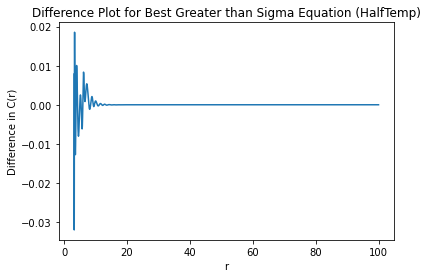

In [49]:
#Difference Plot
plt.plot(halftempg['r'], sub_gt1)
plt.title('Difference Plot for Best Greater than Sigma Equation (HalfTemp)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

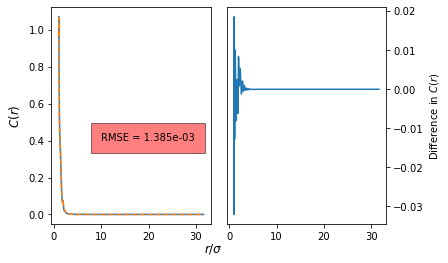

In [50]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.1)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Greater than Sigma Equation at Half Temperature')
ax1.plot(halftempg['r']/sigma, eval(gbest[0])(halftempg['r'], *popt_gt1), label= 'Scipy Optimized Fit for Half Density')
ax1.plot(halftempg['r']/sigma, halftempg['c'], '--', label = 'Raw Data')
ax1.text(10, 0.4, r'RMSE = {:.3e}'.format(RMS_gt1), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(halftempg['r']/sigma, sub_gt1)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

fig.savefig('ljgreat1halftemp.png', dpi=300, bbox_inches = "tight")

### Half Both

In [51]:
#Optimizing Greater Best 1 w/ Half Temp
popt_gtd1, pcov_gtd1 = spopt.curve_fit(eval(gbest[0]), halfbothg['r'].values, halfbothg['c'].values, p0 = popt_gd1)  

In [52]:
sub_gtd1 = np.subtract(halfbothg['c'], eval(gbest[0])(halfbothg['r'], *popt_gtd1))
square_gtd1 = sub_gtd1**2
mean_gtd1 = np.mean(square_gtd1)
RMS_gtd1 = np.sqrt(mean_gtd1)

print(RMS_gtd1)

0.009104189761164921


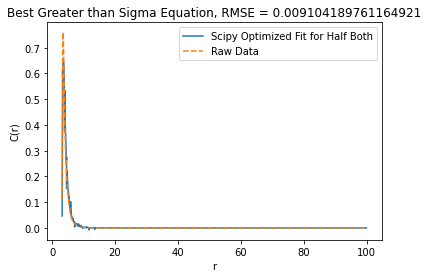

In [53]:
plt.plot(halfbothg['r'], eval(gbest[0])(halfbothg['r'], *popt_gtd1), label= 'Scipy Optimized Fit for Half Both')
plt.plot(halfbothg['r'], halfbothg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_gtd1))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

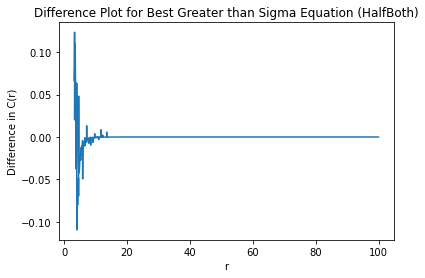

In [54]:
#Difference Plot
plt.plot(halfbothg['r'], sub_gtd1)
plt.title('Difference Plot for Best Greater than Sigma Equation (HalfBoth)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

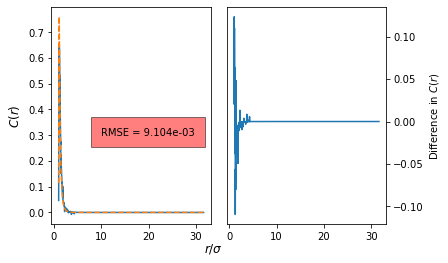

In [55]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.1)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Greater than Sigma Equation at Half Temperature and Density')
ax1.plot(halfbothg['r']/sigma, eval(gbest[0])(halfbothg['r'], *popt_gtd1), label= 'Scipy Optimized Fit for Half Density')
ax1.plot(halfbothg['r']/sigma, halfbothg['c'], '--', label = 'Raw Data')
ax1.text(10, 0.3, r'RMSE = {:.3e}'.format(RMS_gtd1), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(halfbothg['r']/sigma, sub_gtd1)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

fig.savefig('ljgreat1halfboth.png', dpi=300, bbox_inches = "tight")

## Second Best Equation for Greater than Sigma

### Half Density

In [56]:
#Optimizing Greater Best 1 w/ Half Density
popt_gd2, pcov_gd2 = spopt.curve_fit(eval(gbest[1]), halfdensg['r'].values, halfdensg['c'].values, p0 = popt_g2, maxfev=4000)  

In [57]:
sub_gd2 = np.subtract(halfdensg['c'], eval(gbest[1])(halfdensg['r'], *popt_gd2))
square_gd2 = sub_gd2**2
mean_gd2 = np.mean(square_gd2)
RMS_gd2 = np.sqrt(mean_gd2)

print(RMS_gd2)

0.0012788944989218477


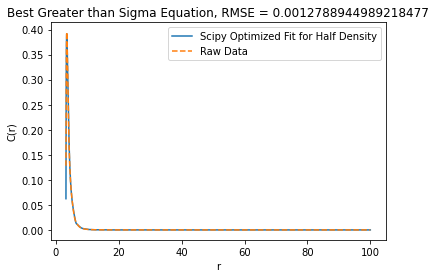

In [58]:
plt.plot(halfdensg['r'], eval(gbest[1])(halfdensg['r'], *popt_gd2), label= 'Scipy Optimized Fit for Half Density')
plt.plot(halfdensg['r'], halfdensg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_gd2))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

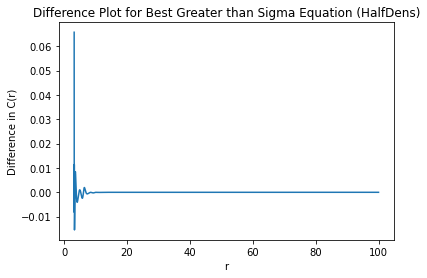

In [59]:
#Difference Plot
plt.plot(halfdensg['r'], sub_gd2)
plt.title('Difference Plot for Best Greater than Sigma Equation (HalfDens)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

### Half Temp

In [60]:
#Optimizing Greater Best 1 w/ Half Temp
popt_gt2, pcov_gt2 = spopt.curve_fit(eval(gbest[1]), halftempg['r'].values, halftempg['c'].values, p0 = g_p0[1])  

In [61]:
sub_gt2 = np.subtract(halftempg['c'], eval(gbest[1])(halftempg['r'], *popt_gt2))
square_gt2 = sub_gt2**2
mean_gt2 = np.mean(square_gt2)
RMS_gt2 = np.sqrt(mean_gt2)

print(RMS_gt2)

0.0015560198843404946


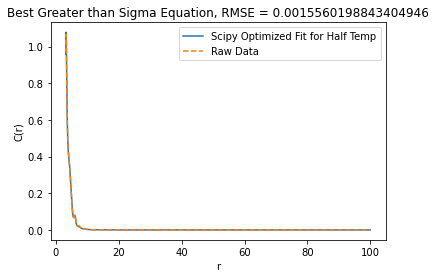

In [62]:
plt.plot(halftempg['r'], eval(gbest[1])(halftempg['r'], *popt_gt2), label= 'Scipy Optimized Fit for Half Temp')
plt.plot(halftempg['r'], halftempg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_gt2))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

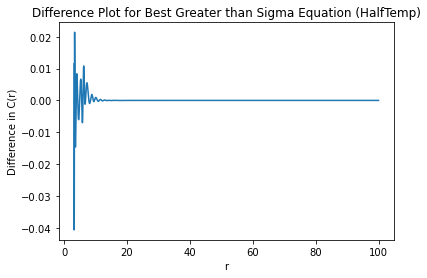

In [63]:
#Difference Plot
plt.plot(halftempg['r'], sub_gt2)
plt.title('Difference Plot for Best Greater than Sigma Equation (HalfTemp)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

### Half Both

In [64]:
#Optimizing Greater Best 1 w/ Half Temp
popt_gtd2, pcov_gtd2 = spopt.curve_fit(eval(gbest[1]), halfbothg['r'].values, halfbothg['c'].values, p0 = g_p0[1])  


In [65]:
sub_gtd2 = np.subtract(halfbothg['c'], eval(gbest[1])(halfbothg['r'], *popt_gtd2))
square_gtd2 = sub_gtd2**2
mean_gtd2 = np.mean(square_gtd2)
RMS_gtd2 = np.sqrt(mean_gtd2)

print(RMS_gtd2)

0.0008783826330825703


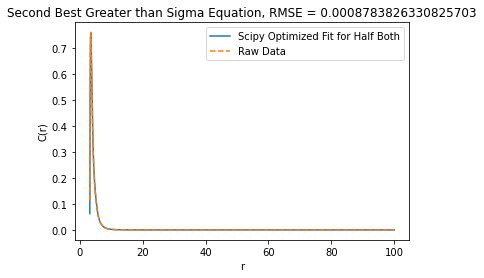

In [66]:
plt.plot(halfbothg['r'], eval(gbest[1])(halfbothg['r'], *popt_gtd2), label= 'Scipy Optimized Fit for Half Both')
plt.plot(halfbothg['r'], halfbothg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Second Best Greater than Sigma Equation, RMSE = {}'.format(RMS_gtd2))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

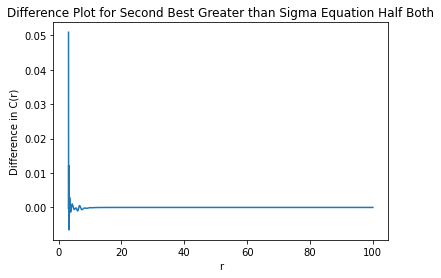

In [67]:
#Difference Plot
plt.plot(halfbothg['r'], sub_gtd2)
plt.title('Difference Plot for Second Best Greater than Sigma Equation Half Both')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

## Third Best Equation from the Greater than Sigma set

### Half Density

In [68]:
#Optimizing Greater Best 1 w/ Half Density
popt_gd3, pcov_gd3 = spopt.curve_fit(eval(gbest[2]), halfdensg['r'].values, halfdensg['c'].values, p0 = g_p0[2], maxfev = 20000)  

In [69]:
sub_gd3 = np.subtract(halfdensg['c'], eval(gbest[2])(halfdensg['r'], *popt_gd3))
square_gd3 = sub_gd3**2
mean_gd3 = np.mean(square_gd3)
RMS_gd3 = np.sqrt(mean_gd3)

print(RMS_gd3)

0.00011304304937422146


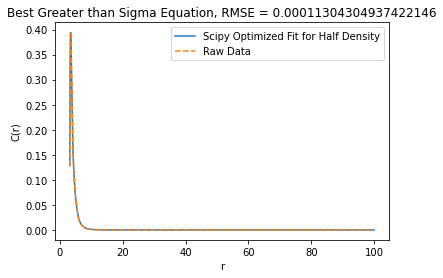

In [70]:
plt.plot(halfdensg['r'], eval(gbest[2])(halfdensg['r'], *popt_gd3), label= 'Scipy Optimized Fit for Half Density')
plt.plot(halfdensg['r'], halfdensg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_gd3))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

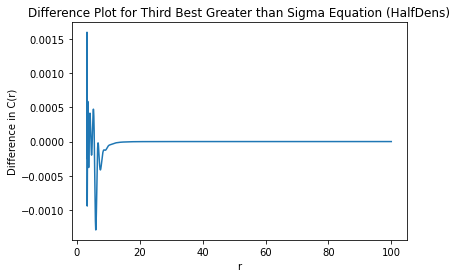

In [71]:
#Difference Plot
plt.plot(halfdensg['r'], sub_gd3)
plt.title('Difference Plot for Third Best Greater than Sigma Equation (HalfDens)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

### Half Temp

In [72]:
#Optimizing Greater Best 1 w/ Half Temp
popt_gt3, pcov_gt3 = spopt.curve_fit(eval(gbest[2]), halftempg['r'].values, halftempg['c'].values, p0 = g_p0[2])  

In [73]:
sub_gt3 = np.subtract(halftempg['c'], eval(gbest[2])(halftempg['r'], *popt_gt3))
square_gt3 = sub_gt3**2
mean_gt3 = np.mean(square_gt3)
RMS_gt3 = np.sqrt(mean_gt3)

print(RMS_gt3)

0.001382786491231236


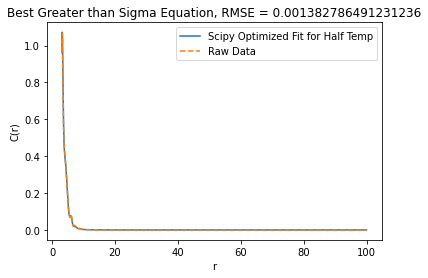

In [74]:
plt.plot(halftempg['r'], eval(gbest[2])(halftempg['r'], *popt_gt3), label= 'Scipy Optimized Fit for Half Temp')
plt.plot(halftempg['r'], halftempg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_gt3))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

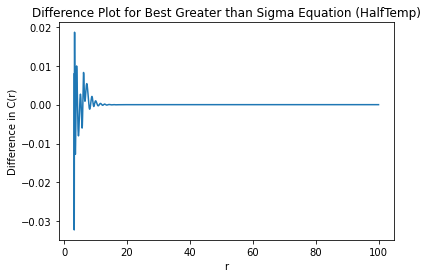

In [75]:
#Difference Plot
plt.plot(halftempg['r'], sub_gt3)
plt.title('Difference Plot for Best Greater than Sigma Equation (HalfTemp)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

### Half Both

In [76]:
#Optimizing Greater Best 1 w/ Half Temp
popt_gtd3, pcov_gtd3 = spopt.curve_fit(eval(gbest[2]), halfbothg['r'].values, halfbothg['c'].values, p0 = g_p0[2], maxfev=20000)

In [77]:
sub_gtd3 = np.subtract(halfbothg['c'], eval(gbest[2])(halfbothg['r'], *popt_gtd3))
square_gtd3 = sub_gtd3**2
mean_gtd3 = np.mean(square_gtd3)
RMS_gtd3 = np.sqrt(mean_gtd3)

print(RMS_gtd3)

0.008718761459389521


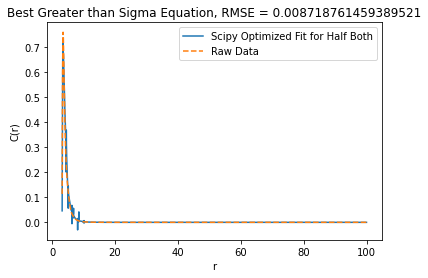

In [78]:
plt.plot(halfbothg['r'], eval(gbest[2])(halfbothg['r'], *popt_gtd3), label= 'Scipy Optimized Fit for Half Both')
plt.plot(halfbothg['r'], halfbothg['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_gtd3))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

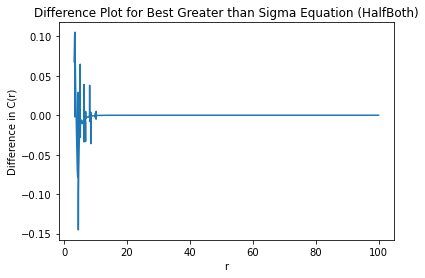

In [79]:
#Difference Plot
plt.plot(halfbothg['r'], sub_gtd3)
plt.title('Difference Plot for Best Greater than Sigma Equation (HalfBoth)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

In [80]:
ave_gd_rmse = (RMS_gd1 + RMS_gd2 + RMS_gd3)/3

print(ave_gd_rmse)

ave_gt_rmse = (RMS_gt1 + RMS_gt2 + RMS_gt3)/3

print(ave_gt_rmse)

ave_gtd_rmse = (RMS_gtd1 + RMS_gtd2 + RMS_gtd3)/3

print(ave_gtd_rmse)

0.0005030077546518304
0.0014414067620700073
0.0062337779512123374


## Best Equation for the Less than Sigma Set

### Half Density

In [81]:
#Optimizing Less Best 1 w/ Half Density
popt_ld1, pcov_ld1 = spopt.curve_fit(eval(lbest[0]), halfdensl['r'].values, halfdensl['c'].values, p0 = l_p0[0], maxfev=200000)

In [82]:
sub_ld1 = np.subtract(halfdensl['c'], eval(lbest[0])(halfdensl['r'], *popt_ld1))
square_ld1 = sub_ld1**2
mean_ld1 = np.mean(square_ld1)
RMS_ld1 = np.sqrt(mean_ld1)

print(RMS_ld1)

0.003448218734259974


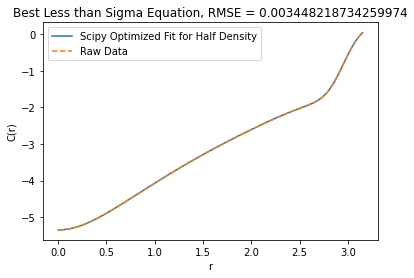

In [83]:
plt.plot(halfdensl['r'], eval(lbest[0])(halfdensl['r'], *popt_ld1), label= 'Scipy Optimized Fit for Half Density')
plt.plot(halfdensl['r'], halfdensl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Less than Sigma Equation, RMSE = {}'.format(RMS_ld1))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

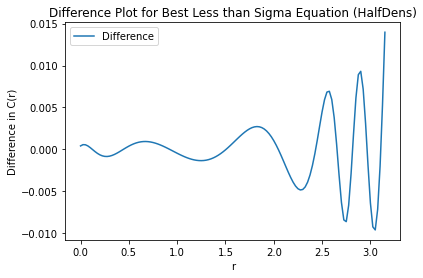

In [84]:
#Difference Plot
plt.plot(halfdensl['r'], sub_ld1, label = 'Difference')
plt.title('Difference Plot for Best Less than Sigma Equation (HalfDens)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
plt.legend()
#plt.yscale('log')
plt.show()

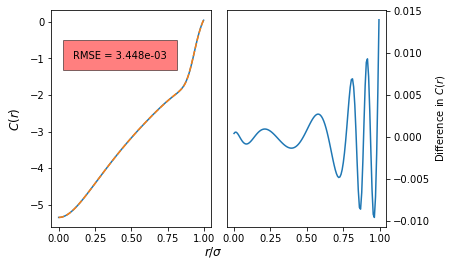

In [85]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.1)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Less than Sigma Equation at Half Density')
ax1.plot(halfdensl['r']/sigma, eval(lbest[0])(halfdensl['r'], *popt_ld1), label= 'Scipy Optimized Fit')
ax1.plot(halfdensl['r']/sigma, halfdensl['c'], '--', label = 'Raw Data')
ax1.text(0.1, -1.0, r'RMSE = {:.3e}'.format(RMS_ld1), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(halfdensl['r']/sigma, sub_ld1)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

fig.savefig('ljless1halfdens.png',  dpi=300, bbox_inches = "tight")

### Half Temp

In [86]:
#Optimizing Less Best 1 w/ Half Density
popt_lt1, pcov_lt1 = spopt.curve_fit(eval(lbest[0]), halftempl['r'].values, halftempl['c'].values, p0 = l_p0[0])  

In [87]:
sub_lt1 = np.subtract(halftempl['c'], eval(lbest[0])(halftempl['r'], *popt_lt1))
square_lt1 = sub_lt1**2
mean_lt1 = np.mean(square_lt1)
RMS_lt1 = np.sqrt(mean_lt1)

print(RMS_lt1)

0.017919678810420874


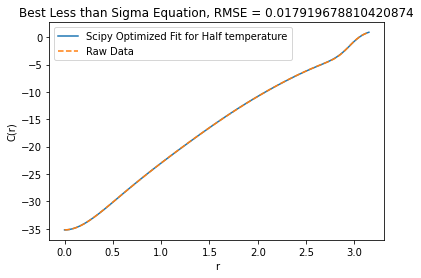

In [88]:
plt.plot(halftempl['r'], eval(lbest[0])(halftempl['r'], *popt_lt1), label= 'Scipy Optimized Fit for Half temperature')
plt.plot(halftempl['r'], halftempl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Less than Sigma Equation, RMSE = {}'.format(RMS_lt1))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

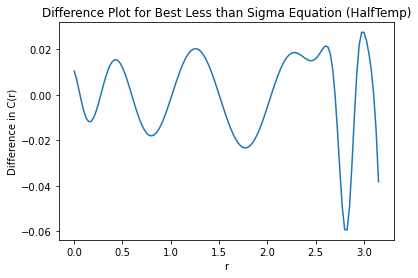

In [89]:
#Difference Plot
plt.plot(halftempl['r'], sub_lt1)
#plt.plot(halfdensl['r'], halfdensl['c'], '--', label = 'Raw Data')
plt.title('Difference Plot for Best Less than Sigma Equation (HalfTemp)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

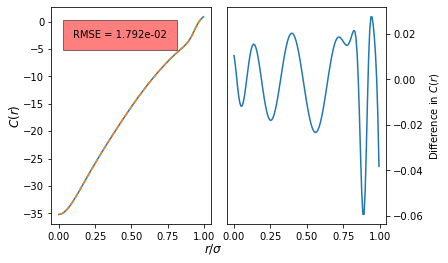

In [90]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.1)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Less than Sigma Equation at Half Temperature')
ax1.plot(halftempl['r']/sigma, eval(lbest[0])(halftempl['r'], *popt_lt1), label= 'Scipy Optimized Fit')
ax1.plot(halftempl['r']/sigma, halftempl['c'], '--', label = 'Raw Data')
ax1.text(0.1, -3, r'RMSE = {:.3e}'.format(RMS_lt1), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(halftempl['r']/sigma, sub_lt1)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

fig.savefig('ljless1halftemp.png', dpi=300, bbox_inches = "tight")

### Half Both

In [91]:
#Optimizing Less Best 1 w/ Half Temp
popt_ltd1, pcov_ltd1 = spopt.curve_fit(eval(lbest[0]), halfbothl['r'].values, halfbothl['c'].values, p0 = popt_ld1, maxfev=100000)

print(popt_ltd1)

print(l_p0[0])

[3.28702322e-01 2.36613952e+01 2.34815671e+03 7.96686794e-01
 8.52169599e-02 1.50576606e+00 7.24296623e-01 1.34140571e+00
 7.42614206e-01]
[7.83928424e+00 4.24589195e+00 1.57354992e+04 7.83742964e-01
 5.53794583e-02 1.52290400e+00 7.32994068e-01 1.33620406e+00
 7.43797491e-01]


In [92]:
sub_ltd1 = np.subtract(halfbothl['c'], eval(lbest[0])(halfbothl['r'], *popt_ltd1))
square_ltd1 = sub_ltd1**2
mean_ltd1 = np.mean(square_ltd1)
RMS_ltd1 = np.sqrt(mean_ltd1)

print(RMS_ltd1)

0.003323692821665955


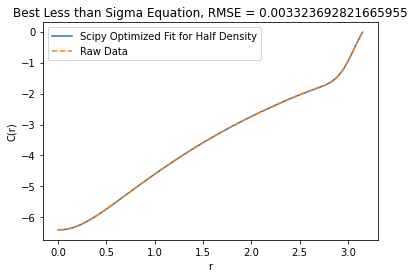

In [93]:
plt.plot(halfbothl['r'], eval(lbest[0])(halfbothl['r'], *popt_ltd1), label= 'Scipy Optimized Fit for Half Density')
plt.plot(halfbothl['r'], halfbothl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Less than Sigma Equation, RMSE = {}'.format(RMS_ltd1))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

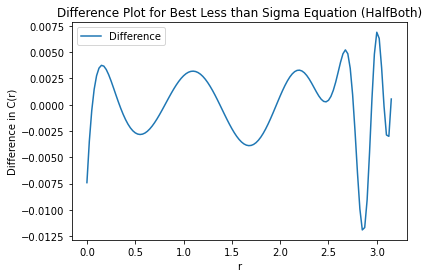

In [94]:
#Difference Plot
plt.plot(halfbothl['r'], sub_ltd1, label = 'Difference')
plt.title('Difference Plot for Best Less than Sigma Equation (HalfBoth)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
plt.legend()
#plt.yscale('log')
plt.show()

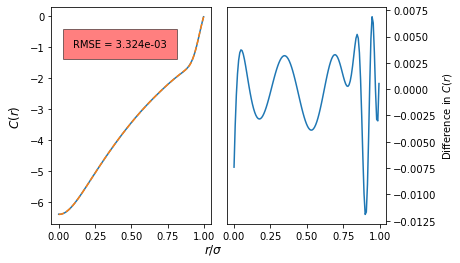

In [95]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.1)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Less than Sigma Equation at Half Temperature and Density')
ax1.plot(halfbothl['r']/sigma, eval(lbest[0])(halfbothl['r'], *popt_ltd1), label= 'Scipy Optimized Fit')
ax1.plot(halfbothl['r']/sigma, halfbothl['c'], '--', label = 'Raw Data')
ax1.text(0.1, -1, r'RMSE = {:.3e}'.format(RMS_ltd1), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(halfbothl['r']/sigma, sub_ltd1)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

fig.savefig('ljless1halfboth.png', dpi=300, bbox_inches = "tight")

## Second Best Equation for Less than Sigma set

### Half Density

In [96]:
#Optimizing Less Best 2 w/ Half Density
popt_ld2, pcov_ld2 = spopt.curve_fit(eval(lbest[1]), halfdensl['r'].values, halfdensl['c'].values, p0 = l_p0[1])  

In [97]:
sub_ld2 = np.subtract(halfdensl['c'], eval(lbest[1])(halfdensl['r'], *popt_ld2))
square_ld2 = sub_ld2**2
mean_ld2 = np.mean(square_ld2)
RMS_ld2 = np.sqrt(mean_ld2)

print(RMS_ld2)

0.011583480998624452


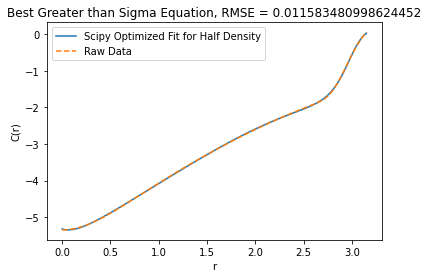

In [98]:
plt.plot(halfdensl['r'], eval(lbest[1])(halfdensl['r'], *popt_ld2), label= 'Scipy Optimized Fit for Half Density')
plt.plot(halfdensl['r'], halfdensl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_ld2))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

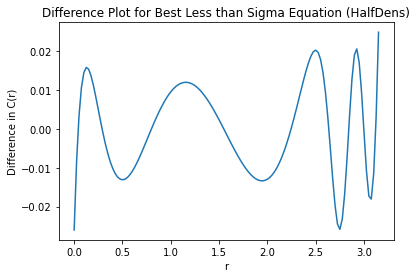

In [99]:
#Difference Plot
plt.plot(halfdensl['r'], sub_ld2)
#plt.plot(halfdensl['r'], halfdensl['c'], '--', label = 'Raw Data')
plt.title('Difference Plot for Best Less than Sigma Equation (HalfDens)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

### Best Temp

In [100]:
#Optimizing Less Best 1 w/ Half Density
popt_lt2, pcov_lt2 = spopt.curve_fit(eval(lbest[1]), halftempl['r'].values, halftempl['c'].values, p0 = l_p0[1])  

In [101]:
sub_lt2 = np.subtract(halftempl['c'], eval(lbest[1])(halftempl['r'], *popt_lt2))
square_lt2 = sub_lt2**2
mean_lt2 = np.mean(square_lt2)
RMS_lt2 = np.sqrt(mean_lt2)

print(RMS_lt2)

0.011666771976841985


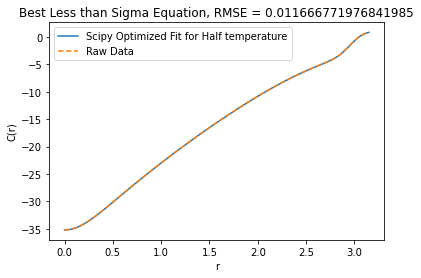

In [102]:
plt.plot(halftempl['r'], eval(lbest[1])(halftempl['r'], *popt_lt2), label= 'Scipy Optimized Fit for Half temperature')
plt.plot(halftempl['r'], halftempl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Less than Sigma Equation, RMSE = {}'.format(RMS_lt2))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

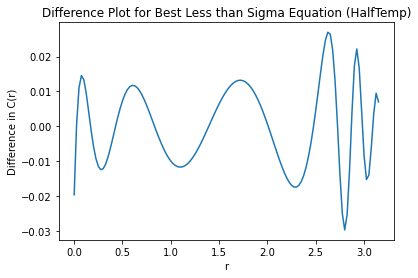

In [103]:
#Difference Plot
plt.plot(halftempl['r'], sub_lt2)
#plt.plot(halfdensl['r'], halfdensl['c'], '--', label = 'Raw Data')
plt.title('Difference Plot for Best Less than Sigma Equation (HalfTemp)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

### Half Both

In [104]:
#Optimizing Less Best 1 w/ Half Temp
popt_ltd2, pcov_ltd2 = spopt.curve_fit(eval(lbest[1]), halfbothl['r'].values, halfbothl['c'].values, p0 = l_p0[1])  

In [105]:
sub_ltd2 = np.subtract(halfbothl['c'], eval(lbest[1])(halfbothl['r'], *popt_ltd2))
square_ltd2 = sub_ltd2**2
mean_ltd2 = np.mean(square_ltd2)
RMS_ltd2 = np.sqrt(mean_ltd2)

print(RMS_ltd2)

0.0032413947364998133


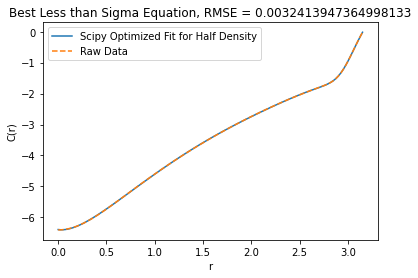

In [106]:
plt.plot(halfbothl['r'], eval(lbest[1])(halfbothl['r'], *popt_ltd2), label= 'Scipy Optimized Fit for Half Density')
plt.plot(halfbothl['r'], halfbothl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Less than Sigma Equation, RMSE = {}'.format(RMS_ltd2))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

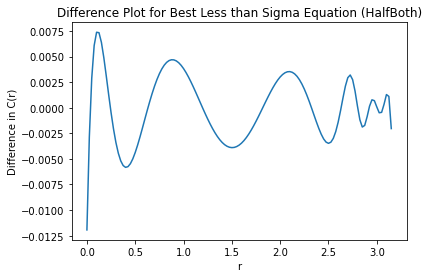

In [107]:
#Difference Plot
plt.plot(halfbothl['r'], sub_ltd2)
#plt.plot(halfbothl['r'], halfbothl['c'], '--', label = 'Raw Data')
plt.title('Difference Plot for Best Less than Sigma Equation (HalfBoth)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

## Third Best Less than Sigma Set

### Half Density

In [108]:
#Optimizing Less Best 2 w/ Half Density
popt_ld3, pcov_ld3 = spopt.curve_fit(eval(lbest[2]), halfdensl['r'].values, halfdensl['c'].values, p0 = l_p0[2], maxfev=30000)  

In [109]:
sub_ld3 = np.subtract(halfdensl['c'], eval(lbest[2])(halfdensl['r'], *popt_ld3))
square_ld3 = sub_ld3**2
mean_ld3 = np.mean(square_ld3)
RMS_ld3 = np.sqrt(mean_ld3)

print(RMS_ld3)

0.004741475484804062


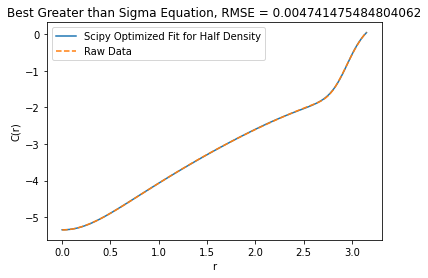

In [110]:
plt.plot(halfdensl['r'], eval(lbest[2])(halfdensl['r'], *popt_ld3), label= 'Scipy Optimized Fit for Half Density')
plt.plot(halfdensl['r'], halfdensl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Greater than Sigma Equation, RMSE = {}'.format(RMS_ld3))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

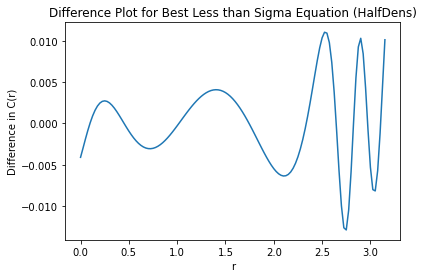

In [111]:
#Difference Plot
plt.plot(halfdensl['r'], sub_ld3)
#plt.plot(halfdensl['r'], halfdensl['c'], '--', label = 'Raw Data')
plt.title('Difference Plot for Best Less than Sigma Equation (HalfDens)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

### Half Temp

In [112]:
#Optimizing Less Best 1 w/ Half Density
popt_lt3, pcov_lt3 = spopt.curve_fit(eval(lbest[2]), halftempl['r'].values, halftempl['c'].values, p0 = l_p0[2])  

In [113]:
sub_lt3 = np.subtract(halftempl['c'], eval(lbest[2])(halftempl['r'], *popt_lt3))
square_lt3 = sub_lt3**2
mean_lt3 = np.mean(square_lt3)
RMS_lt3 = np.sqrt(mean_lt3)

print(RMS_lt3)

0.010370346053008956


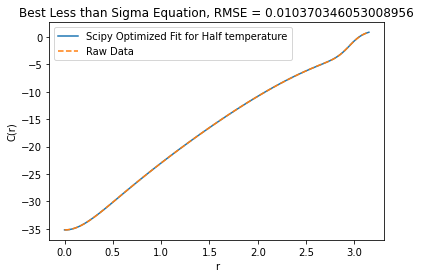

In [114]:
plt.plot(halftempl['r'], eval(lbest[2])(halftempl['r'], *popt_lt3), label= 'Scipy Optimized Fit for Half temperature')
plt.plot(halftempl['r'], halftempl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Less than Sigma Equation, RMSE = {}'.format(RMS_lt3))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

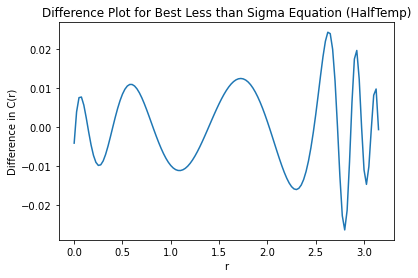

In [115]:
#Difference Plot
plt.plot(halftempl['r'], sub_lt3)
#plt.plot(halfdensl['r'], halfdensl['c'], '--', label = 'Raw Data')
plt.title('Difference Plot for Best Less than Sigma Equation (HalfTemp)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

### Half Both

In [116]:
#Optimizing Less Best 1 w/ Half Temp
popt_ltd3, pcov_ltd3 = spopt.curve_fit(eval(lbest[2]), halfbothl['r'].values, halfbothl['c'].values, p0 = l_p0[2], maxfev = 30000) 

In [117]:
sub_ltd3 = np.subtract(halfbothl['c'], eval(lbest[2])(halfbothl['r'], *popt_ltd3))
square_ltd3 = sub_ltd3**2
mean_ltd3 = np.mean(square_ltd3)
RMS_ltd3 = np.sqrt(mean_ltd3)

print(RMS_ltd3)

0.004245178582512955


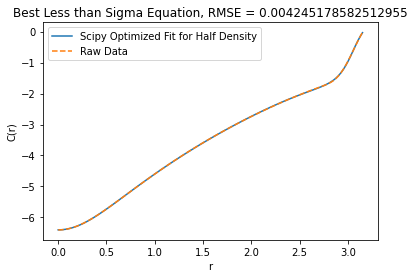

In [118]:
plt.plot(halfbothl['r'], eval(lbest[2])(halfbothl['r'], *popt_ltd3), label= 'Scipy Optimized Fit for Half Density')
plt.plot(halfbothl['r'], halfbothl['c'], '--', label = 'Raw Data')
#plt.plot(dfg['r'], op_gbest1(dfg['r'], *g1_p0), label='Original Fit NMSE = 2.4e-05')
plt.title('Best Less than Sigma Equation, RMSE = {}'.format(RMS_ltd3))
plt.xlabel("r")
plt.ylabel("C(r)")
plt.legend()
#plt.yscale('log')
plt.show()

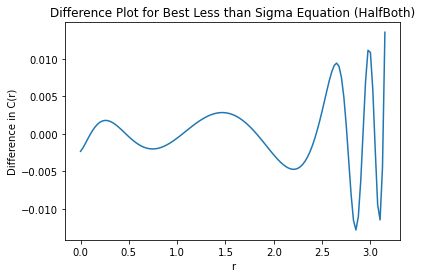

In [119]:
#Difference Plot
plt.plot(halfbothl['r'], sub_ltd3)
#plt.plot(halfbothl['r'], halfbothl['c'], '--', label = 'Raw Data')
plt.title('Difference Plot for Best Less than Sigma Equation (HalfBoth)')
plt.xlabel("r")
plt.ylabel('Difference in C(r)')
#plt.legend()
#plt.yscale('log')
plt.show()

In [120]:
ave_ld_rmse = (RMS_ld1 + RMS_ld2 + RMS_ld3)/3

print(ave_ld_rmse)

ave_lt_rmse = (RMS_lt1 + RMS_lt2 + RMS_lt3)/3

print(ave_lt_rmse)

ave_ltd_rmse = (RMS_ltd1 + RMS_ltd2 + RMS_ltd3)/3

print(ave_ltd_rmse)

0.006591058405896163
0.013318932280090604
0.0036034220468929077


In [121]:
ave_overall_d_rmse = (ave_gd_rmse + ave_ld_rmse)/2

print(ave_overall_d_rmse)

ave_overall_t_rmse = (ave_gt_rmse + ave_lt_rmse)/2

print(ave_overall_t_rmse)

ave_overall_td_rmse = (ave_gtd_rmse + ave_ltd_rmse)/2

print(ave_overall_td_rmse)

0.003547033080273997
0.007380169521080305
0.004918599999052623


In [122]:
complete = pd.concat([eval(lbest[0])(dfl['r'], *popt_l1),eval(gbest[0])(dfg['r'], *popt_g1) ], ignore_index=True)
datacompleteY = pd.concat([dfl['c'],dfg['c']], ignore_index=True)
datacompleteX = pd.concat([dfl['r'], dfg['r']], ignore_index=True)

In [123]:
sub_final = np.subtract(datacompleteY, complete)
square_final = sub_final**2
mean_final = np.mean(square_final)
RMS_final = np.sqrt(mean_final)

print(RMS_final)

0.0010692337477132836


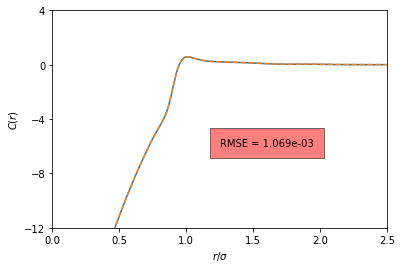

In [124]:
fig, ax = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(6)

tick_spacing = 4
ax.plot(datacompleteX/sigma, complete, label = 'Complete DSO OZ w/ LJ Expression')
ax.plot(datacompleteX/sigma, datacompleteY, '--', label = 'Numerical Model')
ax.set_xlim(0,2.5)
ax.set_ylim(-12,4)
plt.xlabel('$r/\sigma$')
plt.ylabel('$C(r)$')
ax.text(1.25, -6, r'RMSE = {:.3e}'.format(RMS_final), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#fig.savefig('ljfullMLcomparison.png', dpi=300, bbox_inches = "tight")

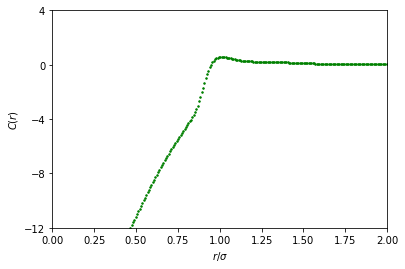

In [166]:
fig, ax = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(6)

tick_spacing = 4
ax.plot(datacompleteX/sigma, datacompleteY, '.', markersize=3, label = 'Numerical Model', color = 'green')
ax.set_xlim(0,2)
ax.set_ylim(-12,4)
plt.xlabel('$r/\sigma$')
plt.ylabel('$C(r)$')
#ax.text(1.25, -6, r'RMSE = {:.3e}'.format(RMS_final), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.savefig('ljfullMLcomparison.png', dpi=300, bbox_inches = "tight")

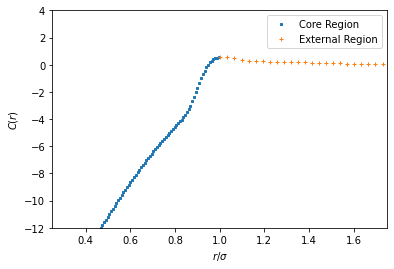

In [164]:
fig, ax = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(6)

fifth = pd.read_csv('lj_hnc_greater_fourth.csv', names = ['r', 'c'], header=None)

#tick_spacing = 4
ax.plot(dfl['r']/sigma, dfl['c'], 's', markersize=2, label = 'Core Region')
ax.plot(fifth['r']/sigma, fifth['c'], '+', markersize=4, label = 'External Region')
ax.set_xlim(0.25,1.75)
ax.set_ylim(-12,4)
plt.xlabel('$r/\sigma$')
plt.ylabel('$C(r)$')
plt.legend()
#ax.text(1.25, -6, r'RMSE = {:.3e}'.format(RMS_final), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax.legend()
#ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.savefig('ljseparationcomparison.png', dpi=300, bbox_inches = "tight")

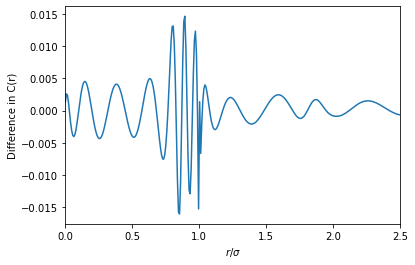

In [126]:
#Difference Plot
plt.plot(datacompleteX/sigma, sub_final)
#plt.plot(halfbothl['r'], halfbothl['c'], '--', label = 'Raw Data')
#plt.title('Difference Plot for Best Less than Sigma Equation (HalfBoth)')
plt.xlabel("$r/\sigma$")
plt.ylabel('Difference in C(r)')
plt.xlim(0,2.5)
#plt.ylim(-12,4)
#plt.legend()
#plt.yscale('log')
plt.show()

Text(0.04, 0.5, '$C(r)$')

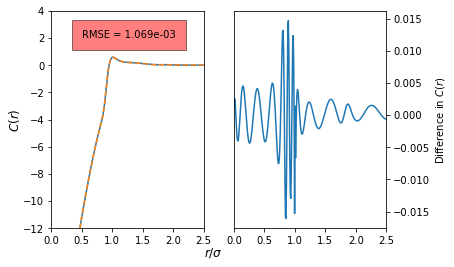

In [127]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(6)

gs = fig.add_gridspec(1,2, wspace=0.2)

(ax1,ax2) = gs.subplots()

#ax1.set_title('Best Less than Sigma Equation at Half Temperature and Density')
ax1.plot(datacompleteX/sigma, complete, label = 'Complete DSO OZ w/ LJ Expression')
ax1.plot(datacompleteX/sigma, datacompleteY, '--', label = 'Numerical Model')
ax1.set_xlim(0,2.5)
ax1.set_ylim(-12,4)
ax1.text(0.5, 2, r'RMSE = {:.3e}'.format(RMS_final), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#ax1.legend()
plt.ylabel('C(r)')

#ax2.set_title('Difference Plot')
ax2.plot(datacompleteX/sigma, sub_final)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlim(0,2.5)
plt.ylabel('Difference in $C(r)$')

fig.text(0.5, 0.04, '$r/\sigma$', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, '$C(r)$', ha='center', va='center', rotation='vertical', fontsize=12)

#fig.savefig('ljless1halfboth.png', dpi=300, bbox_inches = "tight")